In [46]:
# 1 Initial Setup
import datetime
import numpy as np
import pandas as pd
import time
from jqdata import *
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import copy
import pickle

%matplotlib inline

# 定义类'参数分析'
class parameter_analysis(object):
    
    # 定义函数中不同的变量
    def __init__(self, algorithm_id=None):
        self.algorithm_id = algorithm_id            # 回测id
        
        self.params_df = pd.DataFrame()             # 回测中所有调参备选值的内容，列名字为对应修改面两名称，对应回测中的 g.XXXX
        self.results = {}                           # 回测结果的回报率，key 为 params_df 的行序号，value 为
        self.evaluations = {}                       # 回测结果的各项指标，key 为 params_df 的行序号，value 为一个 dataframe
        self.backtest_ids = {}                      # 回测结果的 id
        
        # 新加入的基准的回测结果 id，可以默认为空 ''，则使用回测中设定的基准
        self.benchmark_id = 'f16629492d6b6f4040b2546262782c78'                      
        
        self.benchmark_returns = []                 # 新加入的基准的回测回报率
        self.returns = {}                           # 记录所有回报率
        self.excess_returns = {}                    # 记录超额收益率
        self.log_returns = {}                       # 记录收益率的 log 值
        self.log_excess_returns = {}                # 记录超额收益的 log 值
        self.dates = []                             # 回测对应的所有日期
        self.excess_max_drawdown = {}               # 计算超额收益的最大回撤
        self.excess_annual_return = {}              # 计算超额收益率的年化指标
        self.evaluations_df = pd.DataFrame()        # 记录各项回测指标，除日回报率外
        self.failed_list= []
    
    # 定义排队运行多参数回测函数
    def run_backtest(self,                          #
                     algorithm_id=None,             # 回测策略id
                     running_max=10,                # 回测中同时巡行最大回测数量
                     start_date='2006-01-01',       # 回测的起始日期
                     end_date='2016-11-30',         # 回测的结束日期
                     frequency='day',               # 回测的运行频率
                     initial_cash='1000000',        # 回测的初始持仓金额
                     param_names=[],                # 回测中调整参数涉及的变量
                     param_values=[],               # 回测中每个变量的备选参数值
                     python_version = 3,            # 回测的python版本
                     use_credit =False              # 是否允许消耗积分继续回测
                     ):
        # 当此处回测策略的 id 没有给出时，调用类输入的策略 id
        if algorithm_id == None: algorithm_id=self.algorithm_id
        
        # 生成所有参数组合并加载到 df 中
        # 包含了不同参数具体备选值的排列组合中一组参数的 tuple 的 list
        param_combinations = list(itertools.product(*param_values))
        # 生成一个 dataframe， 对应的列为每个调参的变量，每个值为调参对应的备选值
        to_run_df = pd.DataFrame(param_combinations,dtype='object')
        # 修改列名称为调参变量的名字
        to_run_df.columns = param_names
        
        # 设定运行起始时间和保存格式
        start = time.time()
        # 记录结束的运行回测
        finished_backtests = {}
        # 记录运行中的回测
        running_backtests = {}
        # 计数器
        pointer = 0
        # 总运行回测数目，等于排列组合中的元素个数
        total_backtest_num = len(param_combinations)
        # 记录回测结果的回报率
        all_results = {}
        # 记录回测结果的各项指标
        all_evaluations = {}
        
        # 在运行开始时显示
        print(('【已完成|运行中|待运行】:'), end=' ')
        
        cannot_get = {} #获取失败 , 重试加一
        
        # 当运行回测开始后，如果没有全部运行完全的话：
        while len(finished_backtests)<total_backtest_num:
            # 显示运行、完成和待运行的回测个数
            print(('[%s|%s|%s].' % (len(finished_backtests), 
                                   len(running_backtests), 
                                   (total_backtest_num-len(finished_backtests)-len(running_backtests)) )), end=' ')
            # 记录当前运行中的空位数量
            to_run = min(running_max-len(running_backtests), total_backtest_num-len(running_backtests)-len(finished_backtests))
            # 把可用的空位进行跑回测
            for i in range(pointer, pointer+to_run):
                # 备选的参数排列组合的 df 中第 i 行变成 dict，每个 key 为列名字，value 为 df 中对应的值
                params = to_run_df.iloc[i].to_dict()
                # 记录策略回测结果的 id，调整参数 extras 使用 params 的内容
                backtest = create_backtest(algorithm_id = algorithm_id,
                                           start_date = start_date, 
                                           end_date = end_date, 
                                           frequency = frequency, 
                                           initial_cash = initial_cash, 
                                           extras = params, 
                                           # 再回测中把改参数的结果起一个名字，包含了所有涉及的变量参数值
                                           name = str(params),
                                           python_version = python_version,
                                           use_credit = use_credit
                                           )
                # 记录运行中 i 回测的回测 id
                running_backtests[i] = backtest
            # 计数器计数运行完的数量    
            pointer = pointer+to_run

            # 获取回测结果
            failed = []
            finished = []
            
            # 对于运行中的回测，key 为 to_run_df 中所有排列组合中的序数
            for key in list(running_backtests.keys()):
                # 研究调用回测的结果，running_backtests[key] 为运行中保存的结果 id
                try :
                    back_id = running_backtests[key]
                    bt = get_backtest(back_id)
                    # 获得运行回测结果的状态，成功和失败都需要运行结束后返回，如果没有返回则运行没有结束
                    status = bt.get_status()
                    # 当运行回测失败
                    if status == 'failed':
                        # 失败 list 中记录对应的回测结果 id
                        print('')
                        print((str(params)+'回测失败 : https://www.joinquant.com/algorithm/backtest/detail?backtestId='+back_id))
                        failed.append(key) 
                    # 当运行回测成功时
                    elif status == 'done':
                        # 成功 list 记录对应的回测结果 id，finish 仅记录运行成功的
                        finished.append(key)
                        # 回测回报率记录对应回测的回报率 dict， key to_run_df 中所有排列组合中的序数， value 为回报率的 dict
                        # 每个 value 一个 list 每个对象为一个包含时间、日回报率和基准回报率的 dict
                        all_results[key] = bt.get_results()
                        # 回测回报率记录对应回测结果指标 dict， key to_run_df 中所有排列组合中的序数， value 为回测结果指标的 dataframe
                        all_evaluations[key] = bt.get_risk()
                            # 记录运行中回测结果 id 的 list 中删除失败的运行
                        print('')
                        print((str(params)+'回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId='+back_id))
                except Exception as e:
                    count = cannot_get.get( key)
                    if not count :
                        cannot_get[key] = 1
                        count = 0
                    elif count < 5:
                        cannot_get[key] = count +1
                    else :
                        failed.append(key) 
                    print("获取回测信息{}失败，重试 {} 次 , 共 {} 次 \n {} ".format(back_id, count ,5 ,e) )
                    time.sleep(2)
            # 记录运行中回测结果 id 的 list 中删除失败的运行
            for key in failed:
                finished_backtests[key] = running_backtests.pop(key)
            # 在结束回测结果 dict 中记录运行成功的回测结果 id，同时在运行中的记录中删除该回测
            for key in finished:
                finished_backtests[key] = running_backtests.pop(key)
#                 print (finished_backtests)
            # 当一组同时运行的回测结束时报告时间
            if len(finished_backtests) != 0 and len(finished_backtests) % running_max == 0 and to_run !=0:
                # 记录当时时间
                middle = time.time()
                # 计算剩余时间，假设没工作量时间相等的话
                remain_time = (middle - start) * (total_backtest_num - len(finished_backtests)) / len(finished_backtests)
                # print 当前运行时间
                print(('[已用%s时,尚余%s时,请不要关闭浏览器].' % (str(round((middle - start) / 60.0 / 60.0,3)), 
                                          str(round(remain_time / 60.0 / 60.0,3)))), end=' ')
            self.failed_list  += failed
            # 5秒钟后再跑一下
            time.sleep(5) 
        # 记录结束时间
        end = time.time() 
        print('')
        print(('【回测完成】总用时：%s秒(即%s小时)。' % (str(int(end-start)), 
                                           str(round((end-start)/60.0/60.0,2)))), end=' ')
#         print (to_run_df,all_results,all_evaluations,finished_backtests)
        # 对应修改类内部对应
#         to_run_df = {key:value for key,value in returns.items() if key not in faild}
        self.params_df = to_run_df
#         all_results = {key:value for key,value in all_results.items() if key not in faild}
        self.results = all_results
#         all_evaluations = {key:value for key,value in all_evaluations.items() if key not in faild}
        self.evaluations = all_evaluations
#         finished_backtests = {key:value for key,value in finished_backtests.items() if key not in faild}
        self.backtest_ids = finished_backtests

        
    #7 最大回撤计算方法
    def find_max_drawdown(self, returns):
        # 定义最大回撤的变量
        result = 0
        # 记录最高的回报率点
        historical_return = 0
        # 遍历所有日期
        for i in range(len(returns)):
            # 最高回报率记录
            historical_return = max(historical_return, returns[i])
            # 最大回撤记录
            drawdown = 1-(returns[i] + 1) / (historical_return + 1)
            # 记录最大回撤
            result = max(drawdown, result)
        # 返回最大回撤值
        return result

    # log 收益、新基准下超额收益和相对与新基准的最大回撤
    def organize_backtest_results(self, benchmark_id=None):
        # 若新基准的回测结果 id 没给出
        if benchmark_id==None:
            # 使用默认的基准回报率，默认的基准在回测策略中设定
            self.benchmark_returns = [x['benchmark_returns'] for x in self.results[0]]
        # 当新基准指标给出后    
        else:
            # 基准使用新加入的基准回测结果
            self.benchmark_returns = [x['returns'] for x in get_backtest(benchmark_id).get_results()]
        # 回测日期为结果中记录的第一项对应的日期
        self.dates = [x['time'] for x in self.results[0]]
        
        # 对应每个回测在所有备选回测中的顺序 （key），生成新数据
        # 由 {key：{u'benchmark_returns': 0.022480100091729405,
        #           u'returns': 0.03184566700000002,
        #           u'time': u'2006-02-14'}} 格式转化为：
        # {key: []} 格式，其中 list 为对应 date 的一个回报率 list
        for key in list(self.results.keys()):
            self.returns[key] = [x['returns'] for x in self.results[key]]
        # 生成对于基准（或新基准）的超额收益率
        for key in list(self.results.keys()):
            self.excess_returns[key] = [(x+1)/(y+1)-1 for (x,y) in zip(self.returns[key], self.benchmark_returns)]
        # 生成 log 形式的收益率
        for key in list(self.results.keys()):
            self.log_returns[key] = [log(x+1) for x in self.returns[key]]
        # 生成超额收益率的 log 形式
        for key in list(self.results.keys()):
            self.log_excess_returns[key] = [log(x+1) for x in self.excess_returns[key]]
        # 生成超额收益率的最大回撤
        for key in list(self.results.keys()):
            self.excess_max_drawdown[key] = self.find_max_drawdown(self.excess_returns[key])
        # 生成年化超额收益率
        for key in list(self.results.keys()):
            self.excess_annual_return[key] = (self.excess_returns[key][-1]+1)**(252./float(len(self.dates)))-1
        # 把调参数据中的参数组合 df 与对应结果的 df 进行合并
        self.evaluations_df = pd.concat([self.params_df, pd.DataFrame(self.evaluations).T], axis=1)
#         self.evaluations_df = 

    # 获取最总分析数据，调用排队回测函数和数据整理的函数    
    def get_backtest_data(self,
                          algorithm_id=None,                         # 回测策略id
                          benchmark_id=None,                         # 新基准回测结果id
                          file_name='results.pkl',                   # 保存结果的 pickle 文件名字
                          running_max=10,                            # 最大同时运行回测数量
                          start_date='2006-01-01',                   # 回测开始时间
                          end_date='2016-11-30',                     # 回测结束日期
                          frequency='day',                           # 回测的运行频率
                          initial_cash='1000000',                    # 回测初始持仓资金
                          param_names=[],                            # 回测需要测试的变量
                          param_values=[],                           # 对应每个变量的备选参数
                          python_version = 2,
                          use_credit = False
                          ):
        # 调运排队回测函数，传递对应参数
        self.run_backtest(algorithm_id=algorithm_id,
                          running_max=running_max,
                          start_date=start_date,
                          end_date=end_date,
                          frequency=frequency,
                          initial_cash=initial_cash,
                          param_names=param_names,
                          param_values=param_values,
                          python_version = python_version,
                          use_credit = use_credit,
                          )
        # 回测结果指标中加入 log 收益率和超额收益率等指标
        self.organize_backtest_results(benchmark_id)
        # 生成 dict 保存所有结果。
        results = {'returns':self.returns,
                   'excess_returns':self.excess_returns,
                   'log_returns':self.log_returns,
                   'log_excess_returns':self.log_excess_returns,
                   'dates':self.dates,
                   'benchmark_returns':self.benchmark_returns,
                   'evaluations':self.evaluations,
                   'params_df':self.params_df,
                   'backtest_ids':self.backtest_ids,
                   'excess_max_drawdown':self.excess_max_drawdown,
                   'excess_annual_return':self.excess_annual_return,
                   'evaluations_df':self.evaluations_df,
                    "failed_list" : self.failed_list}
        # 保存 pickle 文件
        pickle_file = open(file_name, 'wb')
        pickle.dump(results, pickle_file)
        pickle_file.close()

    # 读取保存的 pickle 文件，赋予类中的对象名对应的保存内容    
    def read_backtest_data(self, file_name='results.pkl'):
        pickle_file = open(file_name, 'rb')
        results = pickle.load(pickle_file)
        self.returns = results['returns']
        self.excess_returns = results['excess_returns']
        self.log_returns = results['log_returns']
        self.log_excess_returns = results['log_excess_returns']
        self.dates = results['dates']
        self.benchmark_returns = results['benchmark_returns']
        self.evaluations = results['evaluations']
        self.params_df = results['params_df']
        self.backtest_ids = results['backtest_ids']
        self.excess_max_drawdown = results['excess_max_drawdown']
        self.excess_annual_return = results['excess_annual_return']
        self.evaluations_df = results['evaluations_df']
        self.failed_list =  results['failed_list']
    # 回报率折线图    
    def plot_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        # 作图
        for key in list(self.returns.keys()):
            ax.plot(list(range(len(self.returns[key]))), self.returns[key], label=key)
        # 设定benchmark曲线并标记
        ax.plot(list(range(len(self.benchmark_returns))), self.benchmark_returns, label='benchmark', c='k', linestyle='--') 
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        # 设置y标签样式
        ax.set_ylabel('returns',fontsize=20)
        # 设置x标签样式
        ax.set_yticklabels([str(x*100)+'% 'for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title("Strategy's performances with different parameters", fontsize=21)
        plt.xlim(0, len(self.returns[0]))

    # 超额收益率图    
    def plot_excess_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        # 作图
        for key in list(self.returns.keys()):
            ax.plot(list(range(len(self.excess_returns[key]))), self.excess_returns[key], label=key)
        # 设定benchmark曲线并标记
        ax.plot(list(range(len(self.benchmark_returns))), [0]*len(self.benchmark_returns), label='benchmark', c='k', linestyle='--')
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        # 设置y标签样式
        ax.set_ylabel('excess returns',fontsize=20)
        # 设置x标签样式
        ax.set_yticklabels([str(x*100)+'% 'for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title("Strategy's performances with different parameters", fontsize=21)
        plt.xlim(0, len(self.excess_returns[0]))
        
    # log回报率图    
    def plot_log_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        # 作图
        for key in list(self.returns.keys()):
            ax.plot(list(range(len(self.log_returns[key]))), self.log_returns[key], label=key)
        # 设定benchmark曲线并标记
        ax.plot(list(range(len(self.benchmark_returns))), [log(x+1) for x in self.benchmark_returns], label='benchmark', c='k', linestyle='--')
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        # 设置y标签样式
        ax.set_ylabel('log returns',fontsize=20)
        # 设置图片标题样式
        ax.set_title("Strategy's performances with different parameters", fontsize=21)
        plt.xlim(0, len(self.log_returns[0]))
    
    # 超额收益率的 log 图
    def plot_log_excess_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        # 作图
        for key in list(self.returns.keys()):
            ax.plot(list(range(len(self.log_excess_returns[key]))), self.log_excess_returns[key], label=key)
        # 设定benchmark曲线并标记
        ax.plot(list(range(len(self.benchmark_returns))), [0]*len(self.benchmark_returns), label='benchmark', c='k', linestyle='--')
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        # 设置y标签样式
        ax.set_ylabel('log excess returns',fontsize=20)
        # 设置图片标题样式
        ax.set_title("Strategy's performances with different parameters", fontsize=21)
        plt.xlim(0, len(self.log_excess_returns[0]))

        
    # 回测的4个主要指标，包括总回报率、最大回撤夏普率和波动
    def get_eval4_bar(self, sort_by=[]): 
        
        sorted_params = self.params_df
        for by in sort_by:
            sorted_params = sorted_params.sort(by)
        indices = sorted_params.index
        indices = set(sorted_params.index)-set(self.failed_list)
        fig = plt.figure(figsize=(20,7))

        # 定义位置
        ax1 = fig.add_subplot(221)
        # 设定横轴为对应分位，纵轴为对应指标
        ax1.bar(list(range(len(indices))), 
                [self.evaluations[x]['algorithm_return'] for x in indices], 0.6, label = 'Algorithm_return')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax1.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax1.set_ylabel('Algorithm_return', fontsize=15)
        # 设置y标签样式
        ax1.set_yticklabels([str(x*100)+'% 'for x in ax1.get_yticks()])
        # 设置图片标题样式
        ax1.set_title("Strategy's of Algorithm_return performances of different quantile", fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))

        # 定义位置
        ax2 = fig.add_subplot(224)
        # 设定横轴为对应分位，纵轴为对应指标
        ax2.bar(list(range(len(indices))), 
                [self.evaluations[x]['max_drawdown'] for x in indices], 0.6, label = 'Max_drawdown')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax2.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax2.set_ylabel('Max_drawdown', fontsize=15)
        # 设置x标签样式
        ax2.set_yticklabels([str(x*100)+'% 'for x in ax2.get_yticks()])
        # 设置图片标题样式
        ax2.set_title("Strategy's of Max_drawdown performances of different quantile", fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))

        # 定义位置
        ax3 = fig.add_subplot(223)
        # 设定横轴为对应分位，纵轴为对应指标
        ax3.bar(list(range(len(indices))),
                [self.evaluations[x]['sharpe'] for x in indices], 0.6, label = 'Sharpe')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax3.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax3.set_ylabel('Sharpe', fontsize=15)
        # 设置x标签样式
        ax3.set_yticklabels([str(x*100)+'% 'for x in ax3.get_yticks()])
        # 设置图片标题样式
        ax3.set_title("Strategy's of Sharpe performances of different quantile", fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))

        # 定义位置
        ax4 = fig.add_subplot(222)
        # 设定横轴为对应分位，纵轴为对应指标
        ax4.bar(list(range(len(indices))), 
                [self.evaluations[x]['algorithm_volatility'] for x in indices], 0.6, label = 'Algorithm_volatility')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax4.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax4.set_ylabel('Algorithm_volatility', fontsize=15)
        # 设置x标签样式
        ax4.set_yticklabels([str(x*100)+'% 'for x in ax4.get_yticks()])
        # 设置图片标题样式
        ax4.set_title("Strategy's of Algorithm_volatility performances of different quantile", fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))
        
    #14 年化回报和最大回撤，正负双色表示
    def get_eval(self, sort_by=[]):

        sorted_params = self.params_df
        for by in sort_by:
            sorted_params = sorted_params.sort(by)
        indices = sorted_params.index
        indices = set(sorted_params.index)-set(self.failed_list)
        # 大小
        fig = plt.figure(figsize = (20, 8))
        # 图1位置
        ax = fig.add_subplot(111)
        # 生成图超额收益率的最大回撤
        ax.bar([x+0.3 for x in range(len(indices))],
               [-self.evaluations[x]['max_drawdown'] for x in indices], color = '#32CD32',  
                     width = 0.6, label = 'Max_drawdown', zorder=10)
        # 图年化超额收益
        ax.bar([x for x in range(len(indices))],
               [self.evaluations[x]['annual_algo_return'] for x in indices], color = 'r', 
                     width = 0.6, label = 'Annual_return')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax.legend(loc='best',fontsize=15)
        # 基准线
        plt.plot([0, len(indices)], [0, 0], c='k', 
                 linestyle='--', label='zero')
        # 设置图例样式
        ax.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax.set_ylabel('Max_drawdown', fontsize=15)
        # 设置x标签样式
        ax.set_yticklabels([str(x*100)+'% 'for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title("Strategy's performances of different quantile", fontsize=15)
        #   设定x轴长度
        plt.xlim(0, len(indices))


    #14 超额收益的年化回报和最大回撤
    # 加入新的benchmark后超额收益和
    def get_excess_eval(self, sort_by=[]):

        sorted_params = self.params_df
        for by in sort_by:
            sorted_params = sorted_params.sort(by)
        indices = sorted_params.index
        indices = set(sorted_params.index)-set(self.failed_list)
        # 大小
        fig = plt.figure(figsize = (20, 8))
        # 图1位置
        ax = fig.add_subplot(111)
        # 生成图超额收益率的最大回撤
        ax.bar([x+0.3 for x in range(len(indices))],
               [-self.excess_max_drawdown[x] for x in indices], color = '#32CD32',  
                     width = 0.6, label = 'Excess_max_drawdown')
        # 图年化超额收益
        ax.bar([x for x in range(len(indices))],
               [self.excess_annual_return[x] for x in indices], color = 'r', 
                     width = 0.6, label = 'Excess_annual_return')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax.legend(loc='best',fontsize=15)
        # 基准线
        plt.plot([0, len(indices)], [0, 0], c='k', 
                 linestyle='--', label='zero')
        # 设置图例样式
        ax.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax.set_ylabel('Max_drawdown', fontsize=15)
        # 设置x标签样式
        ax.set_yticklabels([str(x*100)+'% 'for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title("Strategy's performances of different quantile", fontsize=15)
        #   设定x轴长度
        plt.xlim(0, len(indices))
        
        
        
        

In [57]:
# 2. Strategy id 
pa = parameter_analysis('9802778aef0d9150cf419997d628da9a')

In [11]:
# 3. Get factors
from jqfactor import get_all_factors 

factors = get_all_factors()

In [12]:
# 3.5 change the data structure to list

factor_list = factors['factor'].tolist()
# get_mtss(['000001.XSHE', '000002.XSHE', '000099.XSHE'], '2015-03-25', '2016-01-25', fields=["date", "sec_code", "sec_value", "fin_buy_value", "sec_sell_value"])

factors

,factor,factor_intro,category,category_intro
0,administration_expense_ttm,管理费用TTM,basics,基础科目及衍生类因子
1,asset_impairment_loss_ttm,资产减值损失TTM,basics,基础科目及衍生类因子
2,cash_flow_to_price_ratio,现金流市值比,basics,基础科目及衍生类因子
3,circulating_market_cap,流通市值,basics,基础科目及衍生类因子
4,EBIT,息税前利润,basics,基础科目及衍生类因子
5,EBITDA,息税折旧摊销前利润,basics,基础科目及衍生类因子
6,financial_assets,金融资产,basics,基础科目及衍生类因子
7,financial_expense_ttm,财务费用TTM,basics,基础科目及衍生类因子
8,financial_liability,金融负债,basics,基础科目及衍生类因子
9,goods_sale_and_service_render_cash_ttm,销售商品提供劳务收到的现金,basics,基础科目及衍生类因子


In [68]:
# 4.1 Building powersets 

# Here we are going to use best subset selection to find the strategy that maximizes the back-tested return 
factor_list_final = ['market_cap','pe_ratio' ,'pb_ratio','pcf_ratio','turnover_ratio','administration_expense']


# building the power set of the list, that's 63 sublist of the list 
from itertools import chain, combinations

def powerset(lst):
    # The chain function concatenates iterators
    # combinations(list, r) gives all combinations of the list with length r
    return [list(subset) for subset in chain.from_iterable(combinations(lst, r) for r in range(1, len(lst) + 1))]

factor_power_list = powerset(factor_list_final)
factor_power_list[:10]


[['market_cap'],
 ['pe_ratio'],
 ['pb_ratio'],
 ['pcf_ratio'],
 ['turnover_ratio'],
 ['administration_expense'],
 ['market_cap', 'pe_ratio'],
 ['market_cap', 'pb_ratio'],
 ['market_cap', 'pcf_ratio'],
 ['market_cap', 'turnover_ratio']]

In [69]:
# 4.2 Backtesting for all subsets of factors
from tqdm import tqdm # tqdm to gauge progress


df_list = []  # List to hold each evaluations_df DataFrame

for subset in tqdm(factor_power_list):
    print(subset)
    pa.get_backtest_data(file_name = 'results.pkl',  
                              running_max = 10,      
                              benchmark_id = None,   
                              start_date = '2022-01-01', #回测开始时间
                              end_date = '2022-11-01',   #回测结束时间
                              frequency = 'day',         
                              initial_cash = '2000000',  
                              param_names = ['factors'],  #变量名称
                              param_values = [[subset]],  #变量对应的参数
                              python_version = 3,   
                              use_credit = True     
                              )
    pa.read_backtest_data('results.pkl')
    df_list.append(pa.evaluations_df)

# Concatenate all the DataFrames in df_list
all_evaluations_df = pd.concat(df_list)

# Now all_evaluations_df contains all the evaluations_df for each subset


  0%|          | 0/63 [00:00<?, ?it/s]

['market_cap']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['market_cap']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=9141d9a8c470e49a0ba9c92793750adc


  2%|▏         | 1/63 [00:56<58:40, 56.78s/it]


【回测完成】总用时：56秒(即0.02小时)。 ['pe_ratio']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['pe_ratio']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=388f2335b67a7d3f8260493801e6b72e


  3%|▎         | 2/63 [01:43<54:35, 53.70s/it]


【回测完成】总用时：46秒(即0.01小时)。 ['pb_ratio']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['pb_ratio']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=59534d3c7d38e43f728944d31d05b343


  5%|▍         | 3/63 [02:24<50:02, 50.05s/it]


【回测完成】总用时：41秒(即0.01小时)。 ['pcf_ratio']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['pcf_ratio']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=9e1a7a3032c4356d3161ad36eb553f2d


  6%|▋         | 4/63 [03:06<46:40, 47.47s/it]


【回测完成】总用时：41秒(即0.01小时)。 ['turnover_ratio']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['turnover_ratio']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=ca3c0f049db4f78d48d543dcdff7570b


  8%|▊         | 5/63 [03:47<44:08, 45.66s/it]


【回测完成】总用时：41秒(即0.01小时)。 ['administration_expense']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['administration_expense']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=75f97f5ec580082922019a82a5901d19


 10%|▉         | 6/63 [04:44<46:31, 48.98s/it]


【回测完成】总用时：56秒(即0.02小时)。 ['market_cap', 'pe_ratio']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['market_cap', 'pe_ratio']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=ae4933384d3cd14d21f2a45dff0cd86d


 11%|█         | 7/63 [05:31<45:02, 48.26s/it]


【回测完成】总用时：46秒(即0.01小时)。 ['market_cap', 'pb_ratio']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['market_cap', 'pb_ratio']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=8cf2b5a7eab87d5a5e074cb798d1a0ee


 13%|█▎        | 8/63 [06:07<41:01, 44.75s/it]


【回测完成】总用时：36秒(即0.01小时)。 ['market_cap', 'pcf_ratio']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['market_cap', 'pcf_ratio']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=ca9d798fa41bd3e16b6c1bcac21cb31c


 14%|█▍        | 9/63 [06:49<39:23, 43.76s/it]


【回测完成】总用时：41秒(即0.01小时)。 ['market_cap', 'turnover_ratio']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['market_cap', 'turnover_ratio']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=6f0c5ecf91e04127996de3c0f774a8bd


 16%|█▌        | 10/63 [07:56<44:49, 50.75s/it]


【回测完成】总用时：67秒(即0.02小时)。 ['market_cap', 'administration_expense']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['market_cap', 'administration_expense']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=c4b8f89b8b24f417a4e50278813aa8f7


 17%|█▋        | 11/63 [08:42<42:55, 49.53s/it]


【回测完成】总用时：46秒(即0.01小时)。 ['pe_ratio', 'pb_ratio']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['pe_ratio', 'pb_ratio']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=3a164c92e297b406f626174dfa844b50


 19%|█▉        | 12/63 [09:39<43:56, 51.70s/it]


【回测完成】总用时：56秒(即0.02小时)。 ['pe_ratio', 'pcf_ratio']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['pe_ratio', 'pcf_ratio']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=a789a40d8df48376e940ff78cec6b98f


 21%|██        | 13/63 [10:26<41:49, 50.18s/it]


【回测完成】总用时：46秒(即0.01小时)。 ['pe_ratio', 'turnover_ratio']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['pe_ratio', 'turnover_ratio']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=4974278a780f3b144c8c00649a0a2bbd


 22%|██▏       | 14/63 [11:12<40:06, 49.11s/it]


【回测完成】总用时：46秒(即0.01小时)。 ['pe_ratio', 'administration_expense']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['pe_ratio', 'administration_expense']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=5a8e9b18226a4335ae82a96139fa71c2


 24%|██▍       | 15/63 [12:14<42:21, 52.96s/it]


【回测完成】总用时：61秒(即0.02小时)。 ['pb_ratio', 'pcf_ratio']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['pb_ratio', 'pcf_ratio']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=97cadf7e813395875be5f35e2f1050df


 25%|██▌       | 16/63 [13:16<43:36, 55.67s/it]


【回测完成】总用时：61秒(即0.02小时)。 ['pb_ratio', 'turnover_ratio']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['pb_ratio', 'turnover_ratio']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=4d59c5126f110174ffc72a9d06d46930


 27%|██▋       | 17/63 [14:18<44:06, 57.53s/it]


【回测完成】总用时：61秒(即0.02小时)。 ['pb_ratio', 'administration_expense']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['pb_ratio', 'administration_expense']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=dec6052eb638f9cbd38436b3a389b971


 29%|██▊       | 18/63 [15:00<39:31, 52.70s/it]


【回测完成】总用时：41秒(即0.01小时)。 ['pcf_ratio', 'turnover_ratio']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['pcf_ratio', 'turnover_ratio']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=a1f2cc3718a73189bebb12e854fa7e8a


 30%|███       | 19/63 [15:41<36:11, 49.35s/it]


【回测完成】总用时：41秒(即0.01小时)。 ['pcf_ratio', 'administration_expense']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['pcf_ratio', 'administration_expense']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=fee348c327f0020fdb38857fc0cf1bde


 32%|███▏      | 20/63 [16:38<36:58, 51.60s/it]


【回测完成】总用时：56秒(即0.02小时)。 ['turnover_ratio', 'administration_expense']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['turnover_ratio', 'administration_expense']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=c98127b40da25179b5bef497d588cfc5


 33%|███▎      | 21/63 [17:24<35:03, 50.08s/it]


【回测完成】总用时：46秒(即0.01小时)。 ['market_cap', 'pe_ratio', 'pb_ratio']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['market_cap', 'pe_ratio', 'pb_ratio']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=0ce8d7dac848837f4d2cc6e915abfeb6


 35%|███▍      | 22/63 [18:06<32:28, 47.52s/it]


【回测完成】总用时：41秒(即0.01小时)。 ['market_cap', 'pe_ratio', 'pcf_ratio']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['market_cap', 'pe_ratio', 'pcf_ratio']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=148a86a2ae472e73918bc7ca42fb9379


 37%|███▋      | 23/63 [18:53<31:29, 47.25s/it]


【回测完成】总用时：46秒(即0.01小时)。 ['market_cap', 'pe_ratio', 'turnover_ratio']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['market_cap', 'pe_ratio', 'turnover_ratio']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=e7b1808f9d9d2292f0ef6b9b0619a693


 38%|███▊      | 24/63 [19:34<29:36, 45.54s/it]


【回测完成】总用时：41秒(即0.01小时)。 ['market_cap', 'pe_ratio', 'administration_expense']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['market_cap', 'pe_ratio', 'administration_expense']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=3136100d3a0b0e23a9c23cdc0a5b1ab9


 40%|███▉      | 25/63 [20:11<27:08, 42.86s/it]


【回测完成】总用时：36秒(即0.01小时)。 ['market_cap', 'pb_ratio', 'pcf_ratio']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['market_cap', 'pb_ratio', 'pcf_ratio']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=f4e94f3d05aaa44712ad7e4b5c892d8b


 41%|████▏     | 26/63 [20:57<27:07, 43.99s/it]


【回测完成】总用时：46秒(即0.01小时)。 ['market_cap', 'pb_ratio', 'turnover_ratio']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['market_cap', 'pb_ratio', 'turnover_ratio']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=2f3d3abd890dba77a2bf9311600f59aa


 43%|████▎     | 27/63 [21:44<26:52, 44.79s/it]


【回测完成】总用时：46秒(即0.01小时)。 ['market_cap', 'pb_ratio', 'administration_expense']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['market_cap', 'pb_ratio', 'administration_expense']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=446729a521f58ad628d3e6b78d509410


 44%|████▍     | 28/63 [22:26<25:33, 43.82s/it]


【回测完成】总用时：41秒(即0.01小时)。 ['market_cap', 'pcf_ratio', 'turnover_ratio']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['market_cap', 'pcf_ratio', 'turnover_ratio']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=77c843a4b68360175dbeb8a8af143e66


 46%|████▌     | 29/63 [23:12<25:19, 44.69s/it]


【回测完成】总用时：46秒(即0.01小时)。 ['market_cap', 'pcf_ratio', 'administration_expense']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['market_cap', 'pcf_ratio', 'administration_expense']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=71d8d7b47aaa7c7cc462200a350d72f3


 48%|████▊     | 30/63 [23:54<24:02, 43.71s/it]


【回测完成】总用时：41秒(即0.01小时)。 ['market_cap', 'turnover_ratio', 'administration_expense']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['market_cap', 'turnover_ratio', 'administration_expense']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=b914227b1540e13c153b2eb2db03a4ac


 49%|████▉     | 31/63 [25:06<27:51, 52.24s/it]


【回测完成】总用时：72秒(即0.02小时)。 ['pe_ratio', 'pb_ratio', 'pcf_ratio']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['pe_ratio', 'pb_ratio', 'pcf_ratio']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=c8f4df1d6a171edd800c2df3cb9f929a


 51%|█████     | 32/63 [25:52<26:06, 50.54s/it]


【回测完成】总用时：46秒(即0.01小时)。 ['pe_ratio', 'pb_ratio', 'turnover_ratio']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['pe_ratio', 'pb_ratio', 'turnover_ratio']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=1eb4f6ba8a08a076eb1fa8c65ee3ac8b


 52%|█████▏    | 33/63 [26:29<23:08, 46.29s/it]


【回测完成】总用时：36秒(即0.01小时)。 ['pe_ratio', 'pb_ratio', 'administration_expense']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['pe_ratio', 'pb_ratio', 'administration_expense']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=53062060152d7bebf8728289e8d1ed58


 54%|█████▍    | 34/63 [27:15<22:24, 46.36s/it]


【回测完成】总用时：46秒(即0.01小时)。 ['pe_ratio', 'pcf_ratio', 'turnover_ratio']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['pe_ratio', 'pcf_ratio', 'turnover_ratio']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=96912b67b9349a5c714eaab48d42d13d


 56%|█████▌    | 35/63 [28:33<25:57, 55.63s/it]


【回测完成】总用时：77秒(即0.02小时)。 ['pe_ratio', 'pcf_ratio', 'administration_expense']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['pe_ratio', 'pcf_ratio', 'administration_expense']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=44619f878087672473bf0383e9b852d3


 57%|█████▋    | 36/63 [29:14<23:07, 51.37s/it]


【回测完成】总用时：41秒(即0.01小时)。 ['pe_ratio', 'turnover_ratio', 'administration_expense']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['pe_ratio', 'turnover_ratio', 'administration_expense']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=2e8201658ec5b5cd45d912c76018fcf7


 59%|█████▊    | 37/63 [30:01<21:40, 50.00s/it]


【回测完成】总用时：46秒(即0.01小时)。 ['pb_ratio', 'pcf_ratio', 'turnover_ratio']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['pb_ratio', 'pcf_ratio', 'turnover_ratio']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=b5a439c3d5d5cbc19ff5e444ca287e7c


 60%|██████    | 38/63 [30:42<19:46, 47.46s/it]


【回测完成】总用时：41秒(即0.01小时)。 ['pb_ratio', 'pcf_ratio', 'administration_expense']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['pb_ratio', 'pcf_ratio', 'administration_expense']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=9244ef94cf945a96d927f4d6d199ada8


 62%|██████▏   | 39/63 [31:24<18:16, 45.67s/it]


【回测完成】总用时：41秒(即0.01小时)。 ['pb_ratio', 'turnover_ratio', 'administration_expense']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['pb_ratio', 'turnover_ratio', 'administration_expense']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=8fd4fcf4c0cdd66f3a04382c22271811


 63%|██████▎   | 40/63 [32:05<17:02, 44.44s/it]


【回测完成】总用时：41秒(即0.01小时)。 ['pcf_ratio', 'turnover_ratio', 'administration_expense']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['pcf_ratio', 'turnover_ratio', 'administration_expense']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=1232c8d9b45a86e8ad0f7660dcb84030


 65%|██████▌   | 41/63 [32:47<15:57, 43.53s/it]


【回测完成】总用时：41秒(即0.01小时)。 ['market_cap', 'pe_ratio', 'pb_ratio', 'pcf_ratio']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['market_cap', 'pe_ratio', 'pb_ratio', 'pcf_ratio']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=27925435bfb7c602b862a4cbe3d788a7


 67%|██████▋   | 42/63 [33:28<15:02, 42.97s/it]


【回测完成】总用时：41秒(即0.01小时)。 ['market_cap', 'pe_ratio', 'pb_ratio', 'turnover_ratio']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['market_cap', 'pe_ratio', 'pb_ratio', 'turnover_ratio']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=b1f067c15bfa80f33924ca06d4a91773


 68%|██████▊   | 43/63 [34:41<17:14, 51.70s/it]


【回测完成】总用时：72秒(即0.02小时)。 ['market_cap', 'pe_ratio', 'pb_ratio', 'administration_expense']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['market_cap', 'pe_ratio', 'pb_ratio', 'administration_expense']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=ddaf407b272ac43339aa567aae24eb10


 70%|██████▉   | 44/63 [35:22<15:24, 48.65s/it]


【回测完成】总用时：41秒(即0.01小时)。 ['market_cap', 'pe_ratio', 'pcf_ratio', 'turnover_ratio']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['market_cap', 'pe_ratio', 'pcf_ratio', 'turnover_ratio']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=c44789f289b0c266d921796d173418de


 71%|███████▏  | 45/63 [36:04<13:56, 46.50s/it]


【回测完成】总用时：41秒(即0.01小时)。 ['market_cap', 'pe_ratio', 'pcf_ratio', 'administration_expense']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['market_cap', 'pe_ratio', 'pcf_ratio', 'administration_expense']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=980a0326bf2a634dac4812f6178e579c


 73%|███████▎  | 46/63 [37:21<15:47, 55.74s/it]


【回测完成】总用时：77秒(即0.02小时)。 ['market_cap', 'pe_ratio', 'turnover_ratio', 'administration_expense']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['market_cap', 'pe_ratio', 'turnover_ratio', 'administration_expense']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=82f2aa97cff92f18251f400ce459fac8


 75%|███████▍  | 47/63 [38:28<15:45, 59.11s/it]


【回测完成】总用时：66秒(即0.02小时)。 ['market_cap', 'pb_ratio', 'pcf_ratio', 'turnover_ratio']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['market_cap', 'pb_ratio', 'pcf_ratio', 'turnover_ratio']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=d8fba3b52f23ce1ab2e03b537568aa47


 76%|███████▌  | 48/63 [39:09<13:27, 53.84s/it]


【回测完成】总用时：41秒(即0.01小时)。 ['market_cap', 'pb_ratio', 'pcf_ratio', 'administration_expense']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['market_cap', 'pb_ratio', 'pcf_ratio', 'administration_expense']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=8a06909f4c3c5003af96dc7ec274bdbc


 78%|███████▊  | 49/63 [39:46<11:20, 48.59s/it]


【回测完成】总用时：36秒(即0.01小时)。 ['market_cap', 'pb_ratio', 'turnover_ratio', 'administration_expense']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['market_cap', 'pb_ratio', 'turnover_ratio', 'administration_expense']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=6a6bcafbe4b21d0df425a945f9867935


 79%|███████▉  | 50/63 [40:58<12:03, 55.66s/it]


【回测完成】总用时：72秒(即0.02小时)。 ['market_cap', 'pcf_ratio', 'turnover_ratio', 'administration_expense']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['market_cap', 'pcf_ratio', 'turnover_ratio', 'administration_expense']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=7f95237ed6b942fd3836a640e5c9210f


 81%|████████  | 51/63 [42:05<11:49, 59.10s/it]


【回测完成】总用时：67秒(即0.02小时)。 ['pe_ratio', 'pb_ratio', 'pcf_ratio', 'turnover_ratio']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['pe_ratio', 'pb_ratio', 'pcf_ratio', 'turnover_ratio']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=227dd83a2e52e92f46d02295387a9b0a


 83%|████████▎ | 52/63 [42:47<09:52, 53.87s/it]


【回测完成】总用时：41秒(即0.01小时)。 ['pe_ratio', 'pb_ratio', 'pcf_ratio', 'administration_expense']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['pe_ratio', 'pb_ratio', 'pcf_ratio', 'administration_expense']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=80bc3f4546540fa2870411cd6f16341c


 84%|████████▍ | 53/63 [43:33<08:37, 51.71s/it]


【回测完成】总用时：46秒(即0.01小时)。 ['pe_ratio', 'pb_ratio', 'turnover_ratio', 'administration_expense']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['pe_ratio', 'pb_ratio', 'turnover_ratio', 'administration_expense']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=cf0b15120afe145f31671f646aef3f16


 86%|████████▌ | 54/63 [44:51<08:54, 59.37s/it]


【回测完成】总用时：77秒(即0.02小时)。 ['pe_ratio', 'pcf_ratio', 'turnover_ratio', 'administration_expense']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['pe_ratio', 'pcf_ratio', 'turnover_ratio', 'administration_expense']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=dd54abe860a050dc5e25e3249a2e385b


 87%|████████▋ | 55/63 [45:37<07:24, 55.55s/it]


【回测完成】总用时：46秒(即0.01小时)。 ['pb_ratio', 'pcf_ratio', 'turnover_ratio', 'administration_expense']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['pb_ratio', 'pcf_ratio', 'turnover_ratio', 'administration_expense']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=881285bba456fbb7aa7f4d49ba671a04


 89%|████████▉ | 56/63 [46:29<06:20, 54.40s/it]


【回测完成】总用时：51秒(即0.01小时)。 ['market_cap', 'pe_ratio', 'pb_ratio', 'pcf_ratio', 'turnover_ratio']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['market_cap', 'pe_ratio', 'pb_ratio', 'pcf_ratio', 'turnover_ratio']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=fb081f65e9be785bf6f33422368a7399


 90%|█████████ | 57/63 [47:36<05:48, 58.16s/it]


【回测完成】总用时：66秒(即0.02小时)。 ['market_cap', 'pe_ratio', 'pb_ratio', 'pcf_ratio', 'administration_expense']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['market_cap', 'pe_ratio', 'pb_ratio', 'pcf_ratio', 'administration_expense']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=aa3f294cd44ec0216720d7b19e12681a


 92%|█████████▏| 58/63 [49:19<05:58, 71.62s/it]


【回测完成】总用时：102秒(即0.03小时)。 ['market_cap', 'pe_ratio', 'pb_ratio', 'turnover_ratio', 'administration_expense']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['market_cap', 'pe_ratio', 'pb_ratio', 'turnover_ratio', 'administration_expense']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=b9e62bc786661f4b48ca110297aa6698


 94%|█████████▎| 59/63 [50:11<04:22, 65.72s/it]


【回测完成】总用时：51秒(即0.01小时)。 ['market_cap', 'pe_ratio', 'pcf_ratio', 'turnover_ratio', 'administration_expense']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['market_cap', 'pe_ratio', 'pcf_ratio', 'turnover_ratio', 'administration_expense']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=e9f851e0183cdbfcc45a65461b3c1d7a


 95%|█████████▌| 60/63 [51:13<03:13, 64.58s/it]


【回测完成】总用时：61秒(即0.02小时)。 ['market_cap', 'pb_ratio', 'pcf_ratio', 'turnover_ratio', 'administration_expense']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['market_cap', 'pb_ratio', 'pcf_ratio', 'turnover_ratio', 'administration_expense']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=555278c4ecc7bbe879ffff5b7e0c7a2f


 97%|█████████▋| 61/63 [52:25<02:13, 66.82s/it]


【回测完成】总用时：72秒(即0.02小时)。 ['pe_ratio', 'pb_ratio', 'pcf_ratio', 'turnover_ratio', 'administration_expense']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['pe_ratio', 'pb_ratio', 'pcf_ratio', 'turnover_ratio', 'administration_expense']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=1ae1931dc8d3715e74e6cbb169ee2be3


 98%|█████████▊| 62/63 [53:37<01:08, 68.40s/it]


【回测完成】总用时：72秒(即0.02小时)。 ['market_cap', 'pe_ratio', 'pb_ratio', 'pcf_ratio', 'turnover_ratio', 'administration_expense']
【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['market_cap', 'pe_ratio', 'pb_ratio', 'pcf_ratio', 'turnover_ratio', 'administration_expense']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=a32236dfb3274924ac2a364d81021cef


100%|██████████| 63/63 [54:49<00:00, 69.51s/it]


【回测完成】总用时：72秒(即0.02小时)。 

In [64]:
pa.get_backtest_data(file_name = 'results.pkl',  
                              running_max = 10,      
                              benchmark_id = None,   
                              start_date = '2022-01-01', #回测开始时间
                              end_date = '2022-11-01',   #回测结束时间
                              frequency = 'day',         
                              initial_cash = '2000000',  
                              param_names = ['factors'],  #变量名称
                              param_values = [[['market_cap', 'pe_ratio']]],  #变量对应的参数
                              python_version = 3,   
                              use_credit = True     
                              )

【已完成|运行中|待运行】: [0|0|1]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. [0|1|0]. 
{'factors': ['market_cap', 'pe_ratio']}回测成功 : https://www.joinquant.com/algorithm/backtest/detail?backtestId=087e7645a7f092cb4f3eef2761b78599

【回测完成】总用时：41秒(即0.01小时)。 

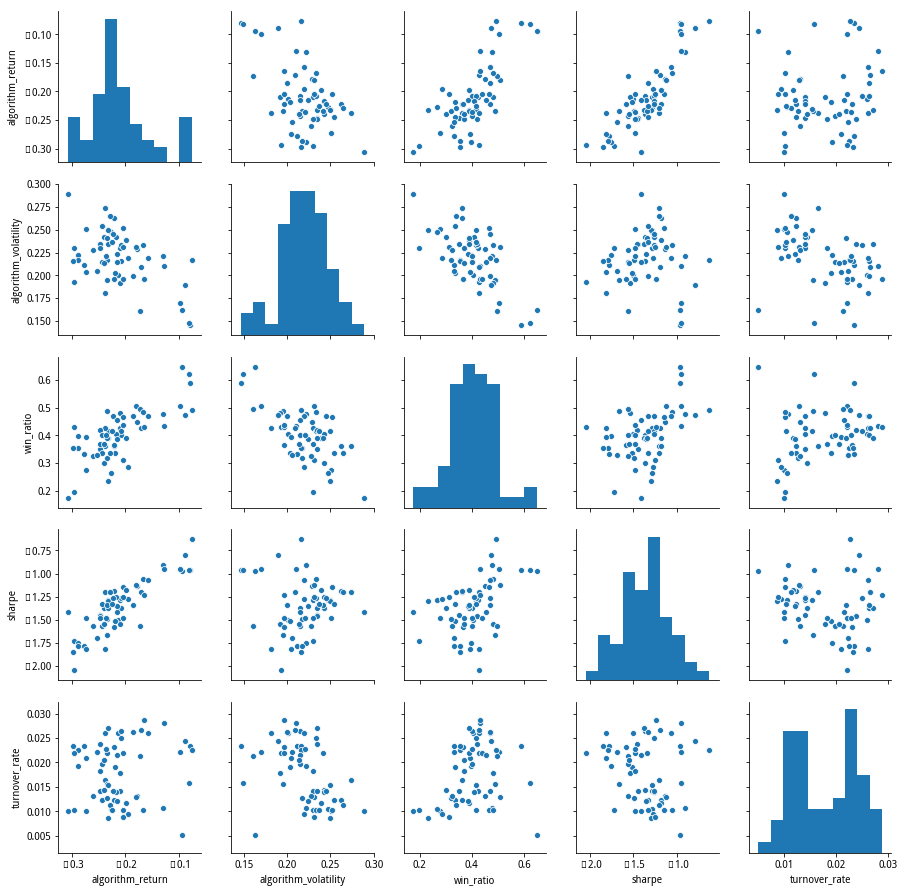

In [102]:
result_df = all_evaluations_df.copy()

# Assuming your data is stored in a DataFrame called 'data_df'
columns_to_plot = ['algorithm_return', 'algorithm_volatility', 'win_ratio', 'sharpe', 'turnover_rate']

# Check data types of each column
#print(result_df.dtypes)

# Convert numeric columns to float if needed
result_df[columns_to_plot] = result_df[columns_to_plot].astype(float)

# Check for any missing or NaN values
#print(result_df[columns_to_plot].isnull().sum())

# Create pairplot
sns.pairplot(result_df[columns_to_plot])
plt.show()

In [91]:
result_sorted = result_df.sort_values('algorithm_return', ascending=False)
result_sorted.head()

,factors,__version,algorithm_return,algorithm_volatility,alpha,annual_algo_return,annual_bm_return,avg_excess_return,avg_position_days,avg_trade_return,benchmark_return,benchmark_volatility,beta,day_win_ratio,excess_return,excess_return_max_drawdown,excess_return_max_drawdown_period,excess_return_sharpe,information,lose_count,max_drawdown,max_drawdown_period,max_leverage,period_label,profit_loss_ratio,sharpe,sortino,trading_days,treasury_return,turnover_rate,win_count,win_ratio
0,"[market_cap, pe_ratio, turnover_ratio, adminis...",101,-0.0770501,0.216303,0.182978,-0.095822,-0.320062,0.00116766,68.3621,-0.00087166,-0.264393,0.207698,0.885404,0.542714,0.254678,0.0410421,"[2022-04-21, 2022-04-28]",2.48801,1.92741,58,0.220164,"[2022-01-05, 2022-04-26]",0,2022-11,0.96772,-0.627925,-0.925483,199,0.0329863,0.022586,56,0.491228
0,[turnover_ratio],101,-0.0803908,0.145799,0.0498856,-0.0999316,-0.320062,0.00116014,89.4318,0.00533721,-0.264393,0.207698,0.52718,0.577889,0.250137,0.118465,"[2022-04-26, 2022-06-28]",2.06327,1.60069,59,0.126694,"[2022-02-11, 2022-03-15]",0,2022-11,0.687814,-0.95976,-1.33828,199,0.0329863,0.0234442,84,0.587413
0,"[turnover_ratio, administration_expense]",101,-0.0821512,0.148243,0.0303036,-0.102096,-0.320062,0.00116027,109.722,0.0110163,-0.264393,0.207698,0.478805,0.567839,0.247744,0.121596,"[2022-04-25, 2022-07-04]",1.81743,1.41273,46,0.141127,"[2022-02-11, 2022-10-31]",0,2022-11,0.568952,-0.958531,-1.33898,199,0.0329863,0.0157058,76,0.622951
0,"[market_cap, turnover_ratio, administration_ex...",101,-0.0890142,0.189611,0.108042,-0.110522,-0.320062,0.00110932,66.9492,-0.00359189,-0.264393,0.207698,0.718112,0.582915,0.238414,0.0633544,"[2022-04-25, 2022-06-08]",2.04381,1.60077,68,0.169444,"[2022-01-20, 2022-04-26]",0,2022-11,0.929653,-0.793845,-1.08557,199,0.0329863,0.0244105,61,0.472868
0,[administration_expense],101,-0.0946581,0.16271,0.0229712,-0.117439,-0.320062,0.00109634,173.043,0.0255429,-0.264393,0.207698,0.501055,0.562814,0.230742,0.136828,"[2022-04-26, 2022-07-14]",1.58803,1.24744,32,0.172789,"[2022-02-11, 2022-10-31]",0,2022-11,0.853065,-0.967609,-1.37638,199,0.0329863,0.00511945,59,0.648352


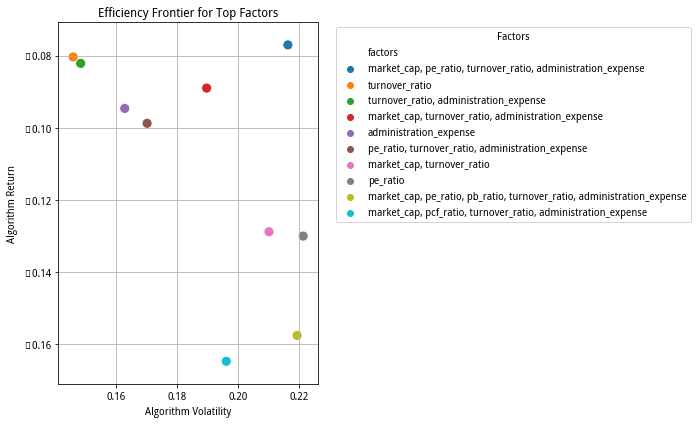

In [88]:
top_factors = result_sorted.iloc[:10][['factors', 'algorithm_return', 'algorithm_volatility']]
top_factors
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the 'factors' column to strings by joining the elements of the list
top_factors['factors'] = top_factors['factors'].apply(lambda x: ', '.join(x)) # implicit fn

# Plot the efficiency frontier
plt.figure(figsize=(10, 6))
sns.scatterplot(x='algorithm_volatility', y='algorithm_return', data=top_factors, hue='factors', s=100)

# Add labels and title
plt.xlabel('Algorithm Volatility')
plt.ylabel('Algorithm Return')
plt.title('Efficiency Frontier for Top Factors')

# Show the plot
plt.legend(title='Factors', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [89]:
# From the plot, we find that turnover ratio being the most important factor in 2022, with the lowest volatility and highest return.